In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import AutoMinorLocator
from scipy.interpolate import LinearNDInterpolator
import multiprocessing

In [2]:
[f.name for f in matplotlib.font_manager.fontManager.ttflist if f.name[:2] == "cm"]

['cmsy10',
 'cmss10',
 'cmmi10',
 'cmr10',
 'cmb10',
 'cmtt10',
 'cmex10',
 'cmsy10',
 'cmr10',
 'cmmi10',
 'cmex10']

In [3]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'cmr10'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["axes.formatter.use_mathtext"] = True

In [4]:

isotopes = [
    'c12', 
    'o16', 
    'ne20', 
    'na23',
]


trace = [
    'na23',
]

color = {
    'c12': 'slateblue',
    'o16': 'orangered',
    'ne20': 'forestgreen',
    'na23': 'darkorange',
}


ls = {
    'c12': 'solid',
    'o16': 'dashed',
    'ne20': 'dotted',
    'na23': 'solid',
}


labels = {
    'c12': '$^{12}$C',
    'o16': '$^{16}$O',
    'ne20': '$^{20}$Ne',
    'na23': '$^{23}$Na',
}

In [94]:
m = 10
g = -10
key = f'm{m:04.1f}_g{g:+04.2f}_0'
index = pd.read_csv(f'csv/{key}/index.csv')
t = np.array(index["time to core O depletion (years)"])
N = np.array(index["surface num_a (/s)"])
slices = [ pd.read_csv(f'csv/{key}/slice_{int(i)}.csv') for i in index["slice"] ]

In [95]:
cm_per_Rsun = 6.957e10
g_per_Msun = 1.998e33
G_cgs = 6.674e-8
c_cgs = 2.998e10
E0_ev = 4.402e5

/tmp/ipykernel_5338/2447293123.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (hist, nax) = plt.subplots(ncols=2, figsize=(7, 3))


ValueError: 2700 is not in list

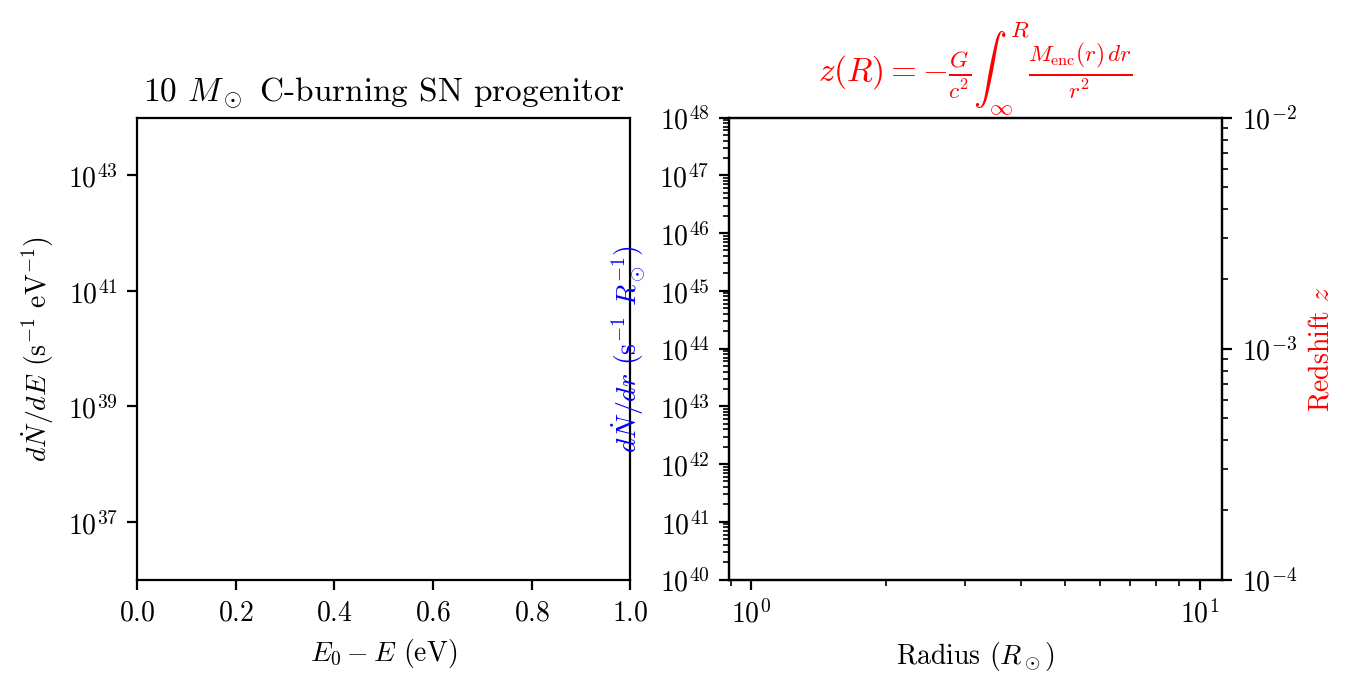

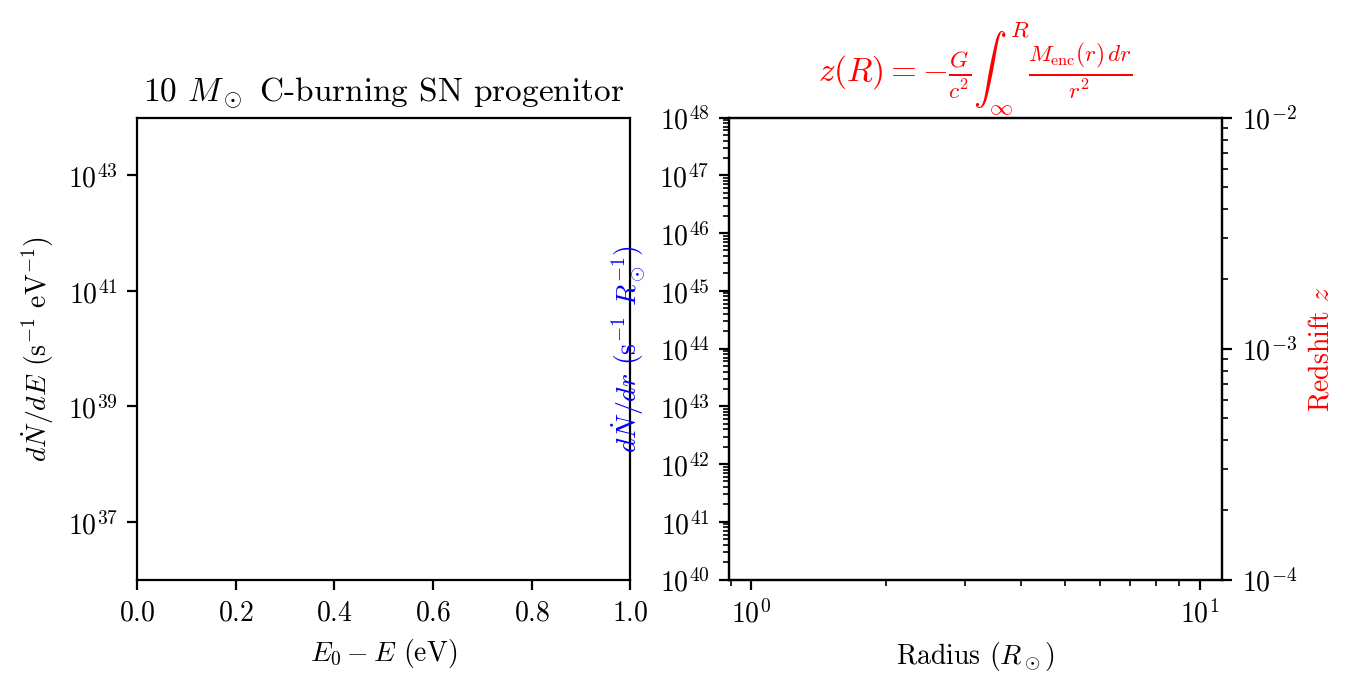

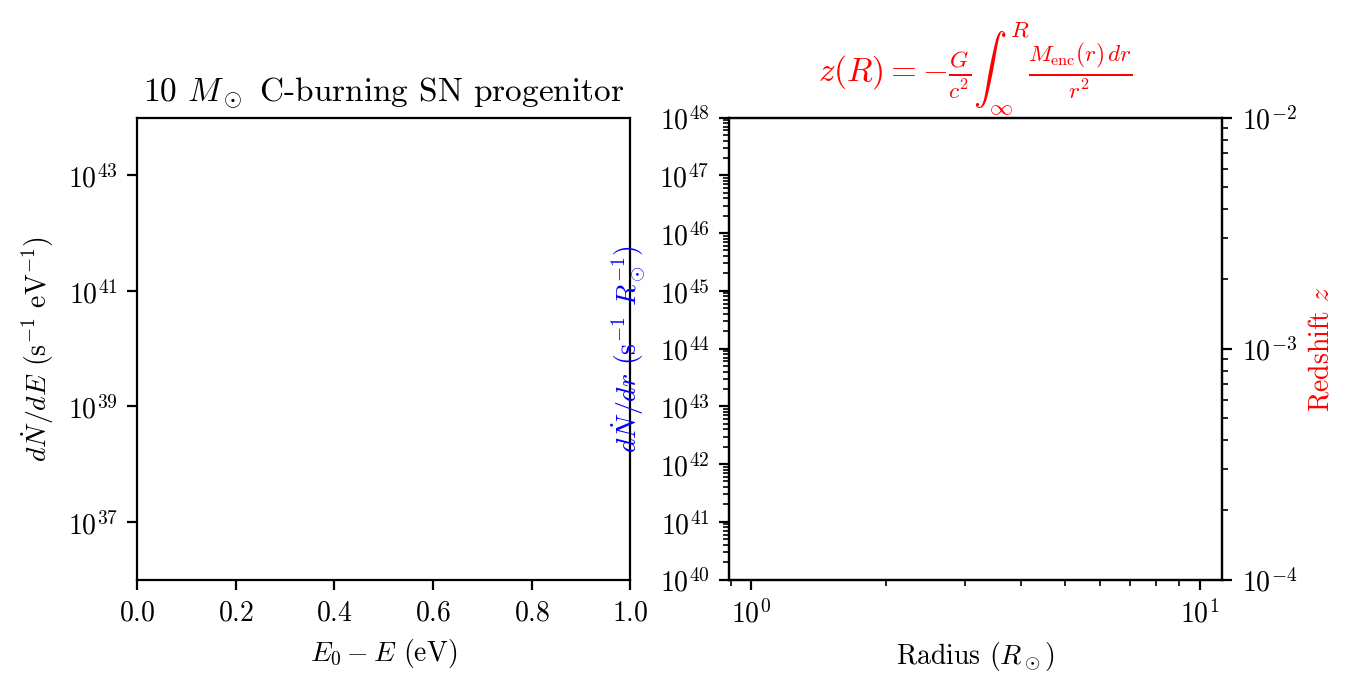

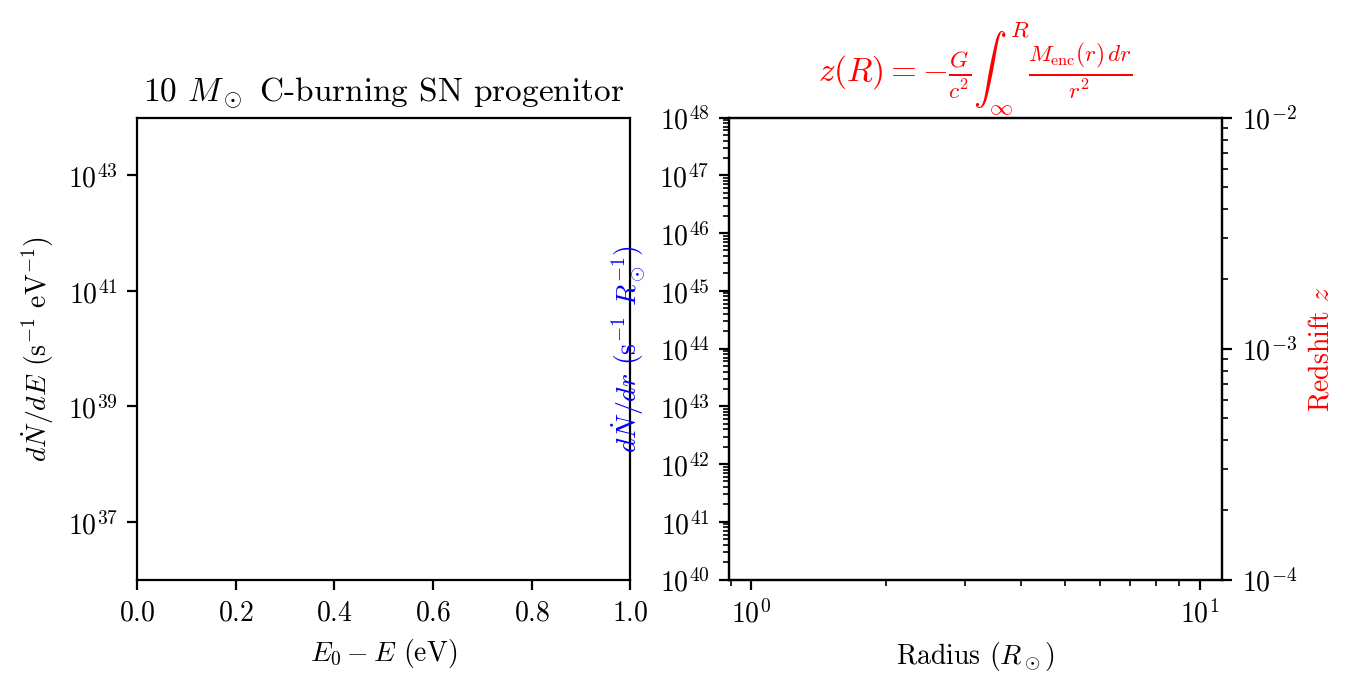

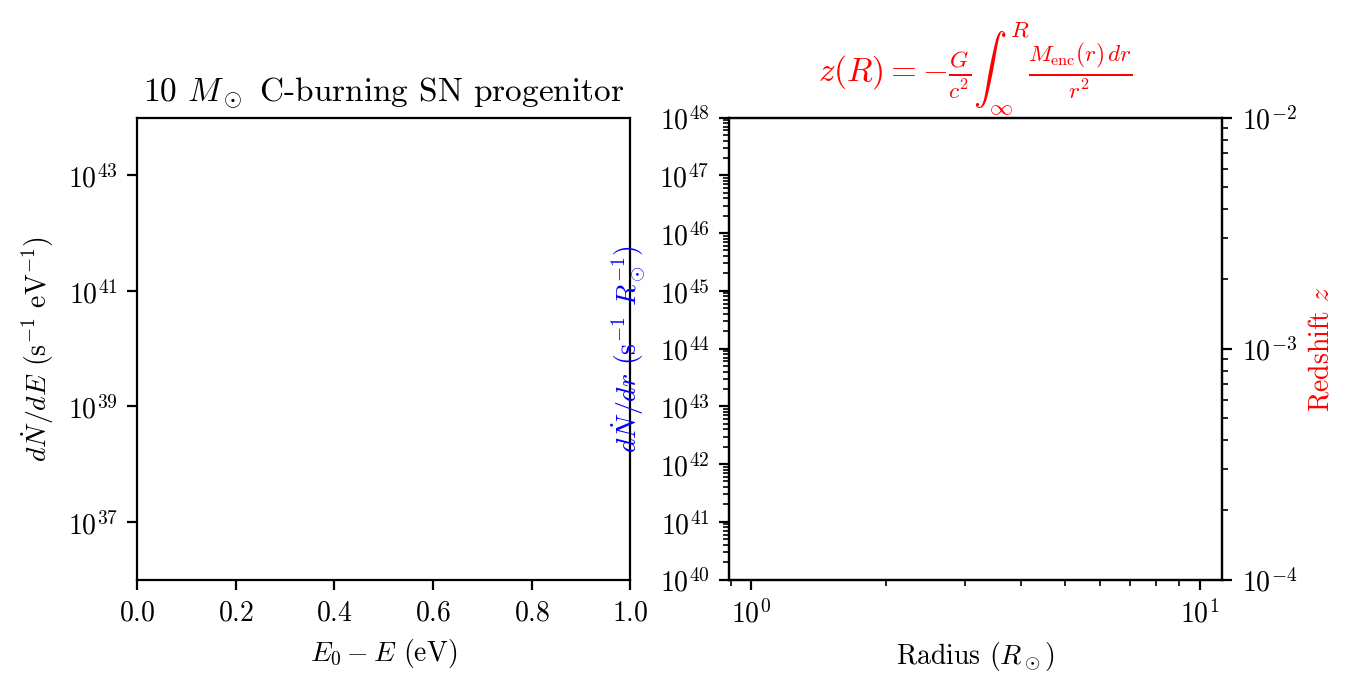

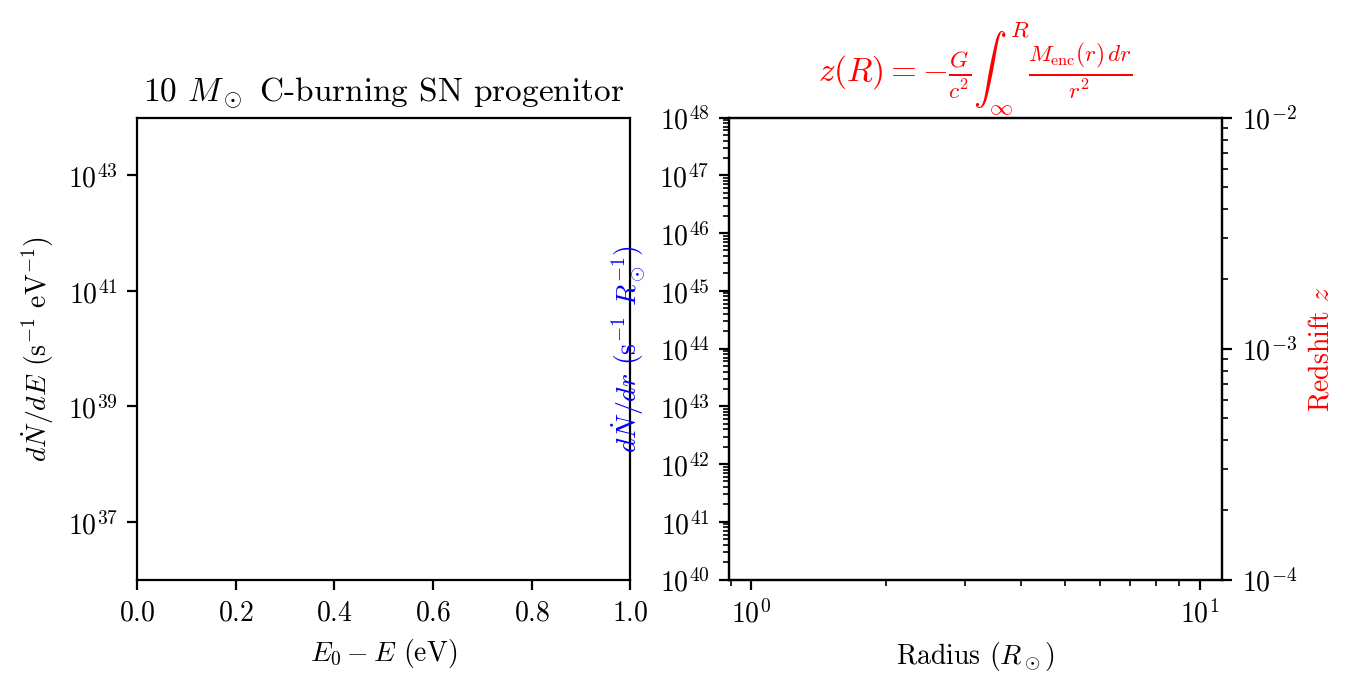

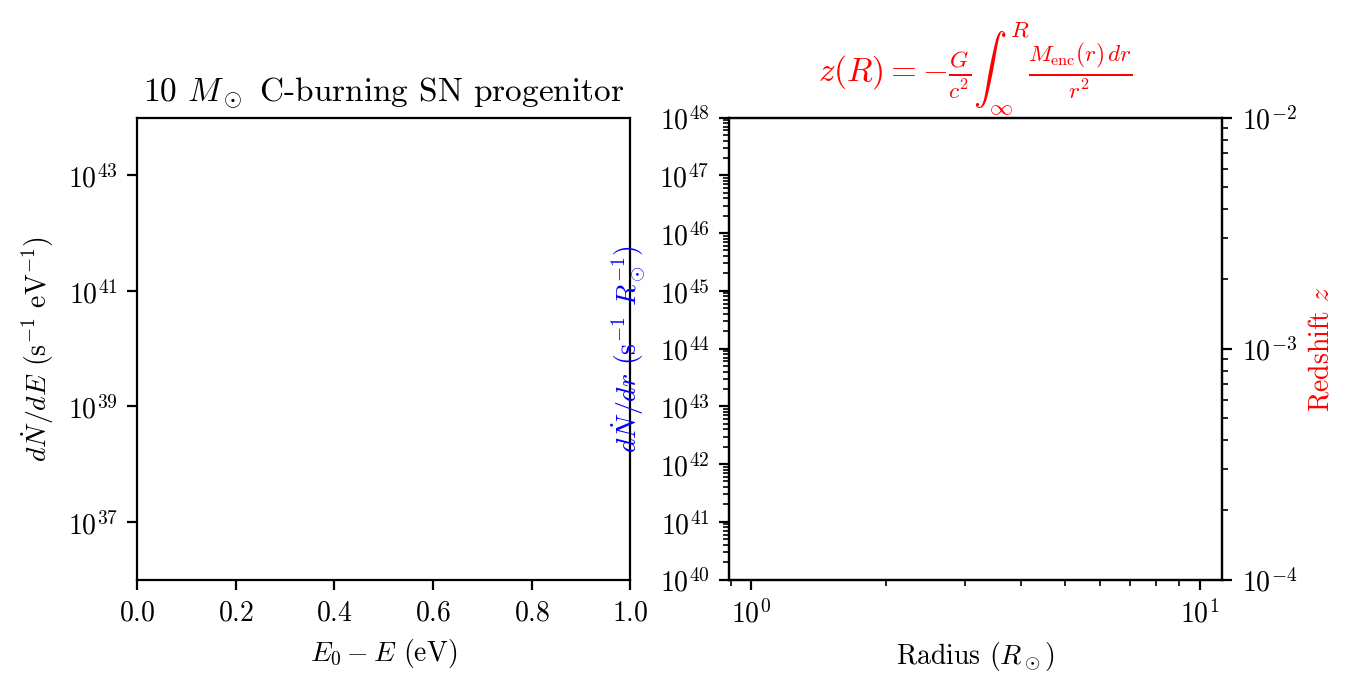

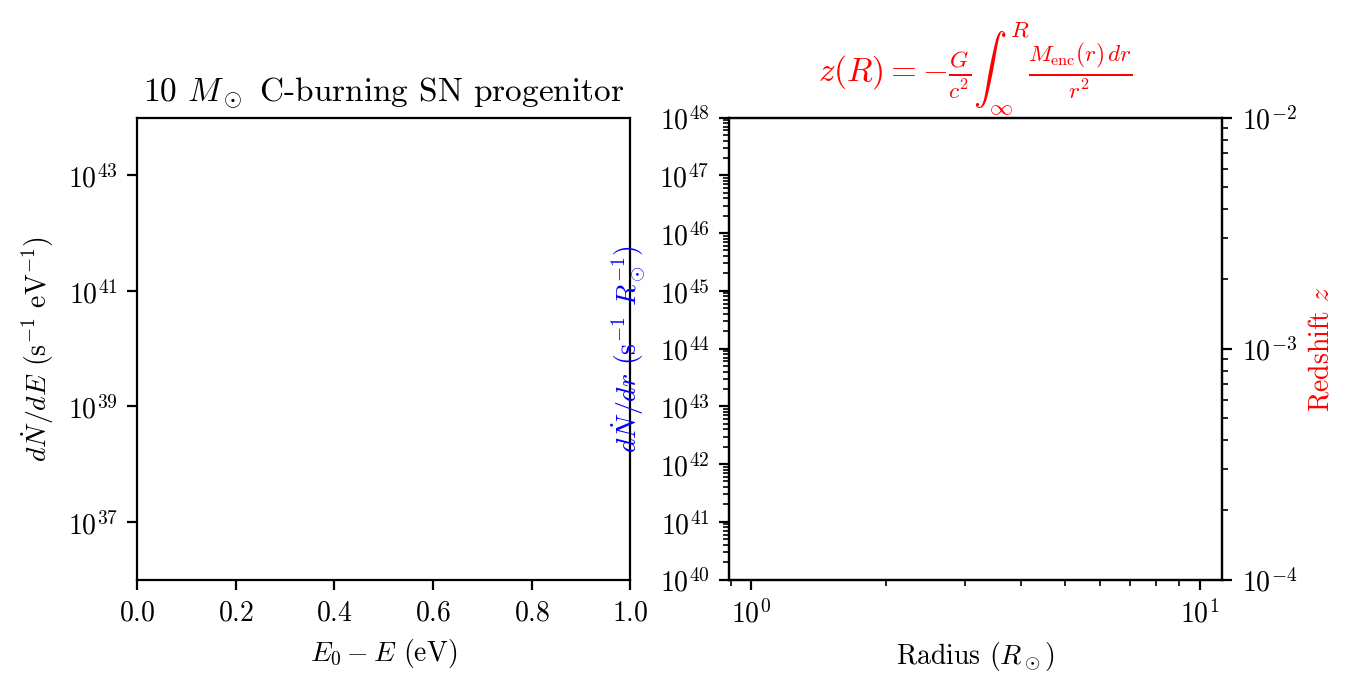

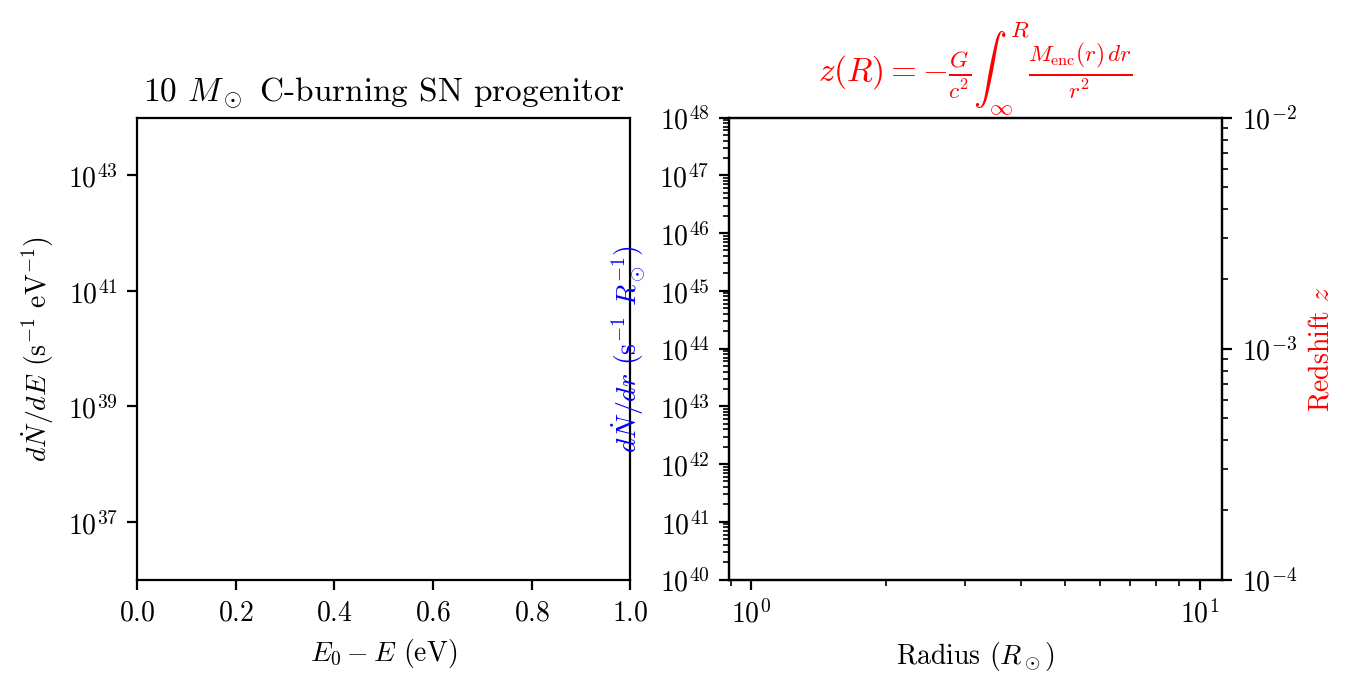

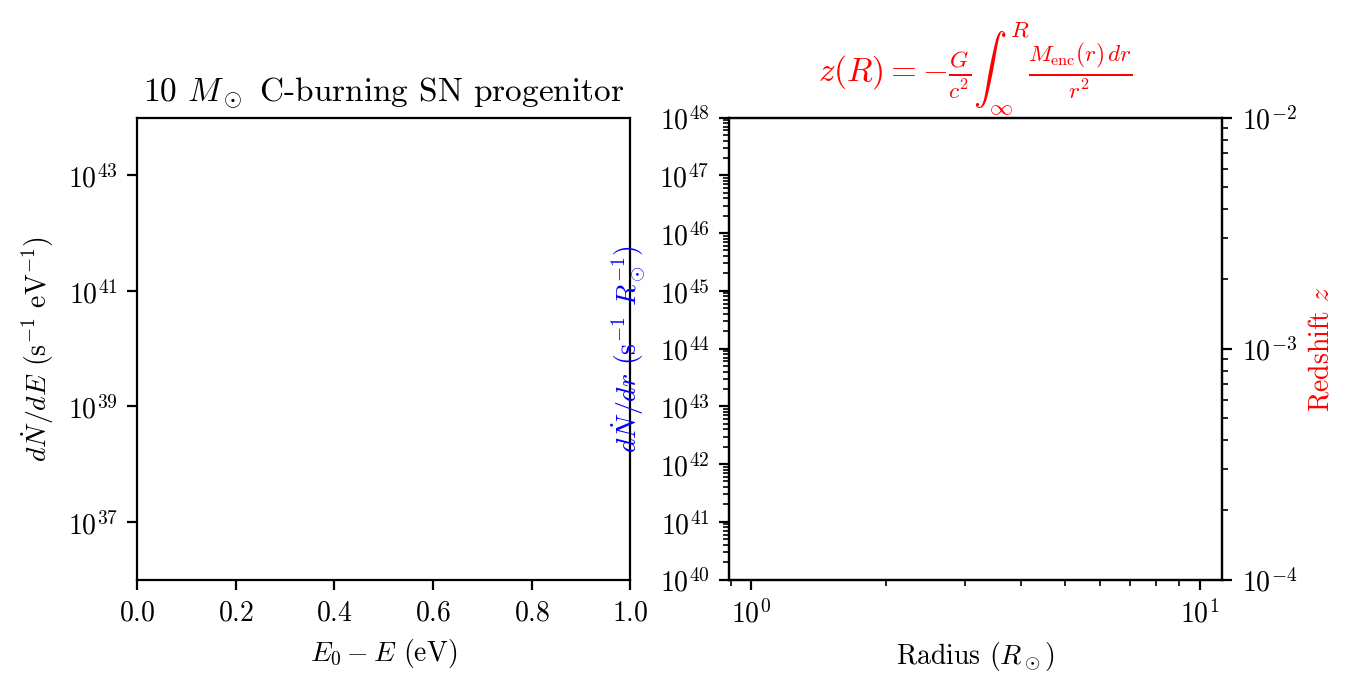

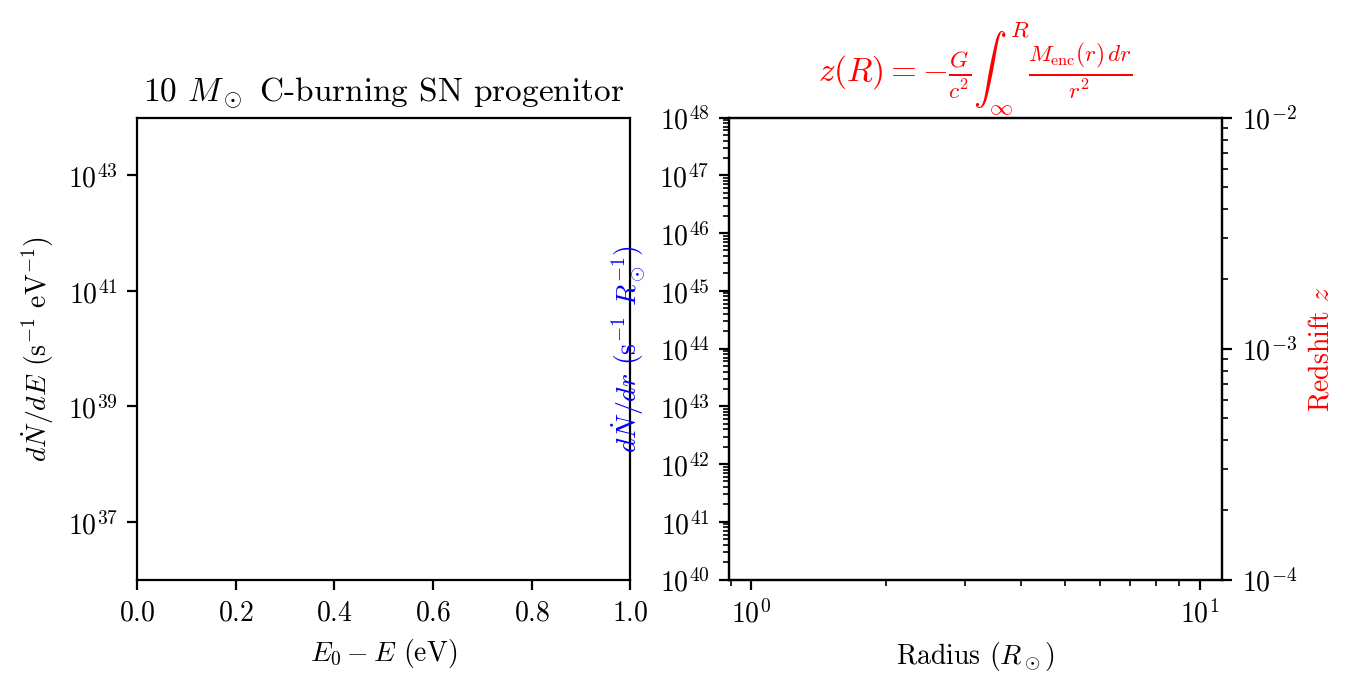

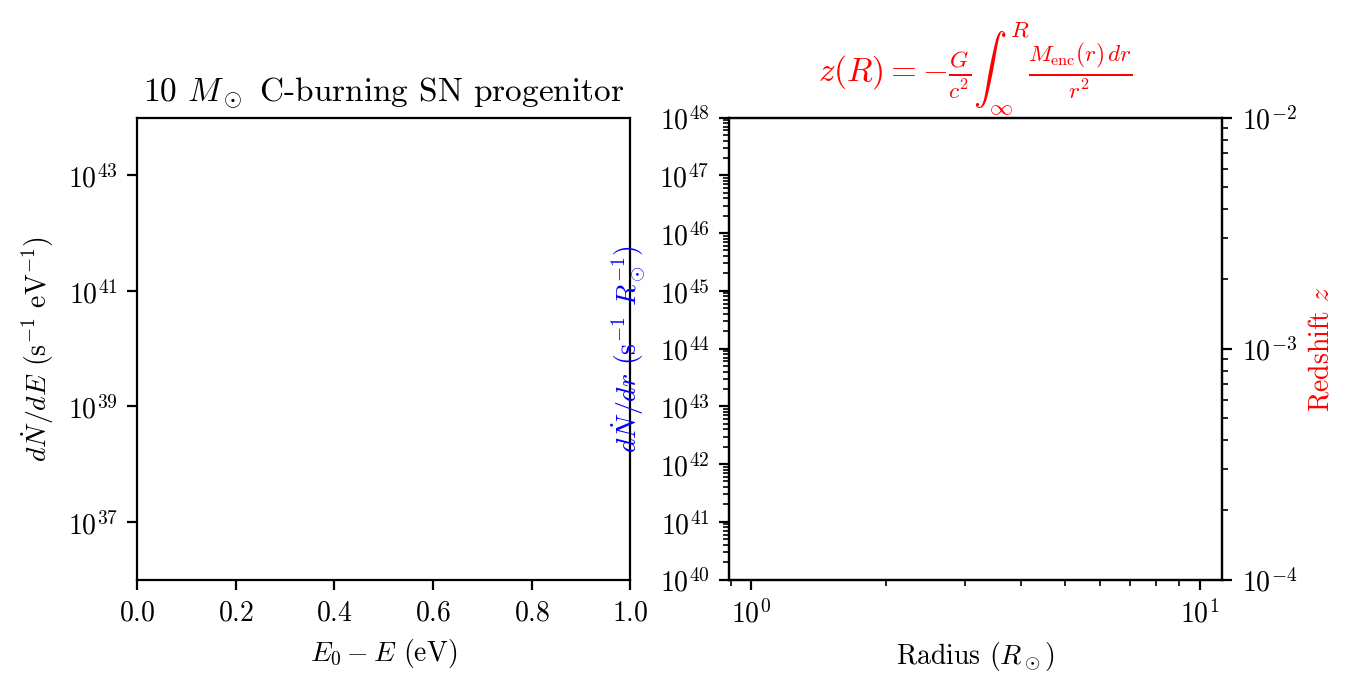

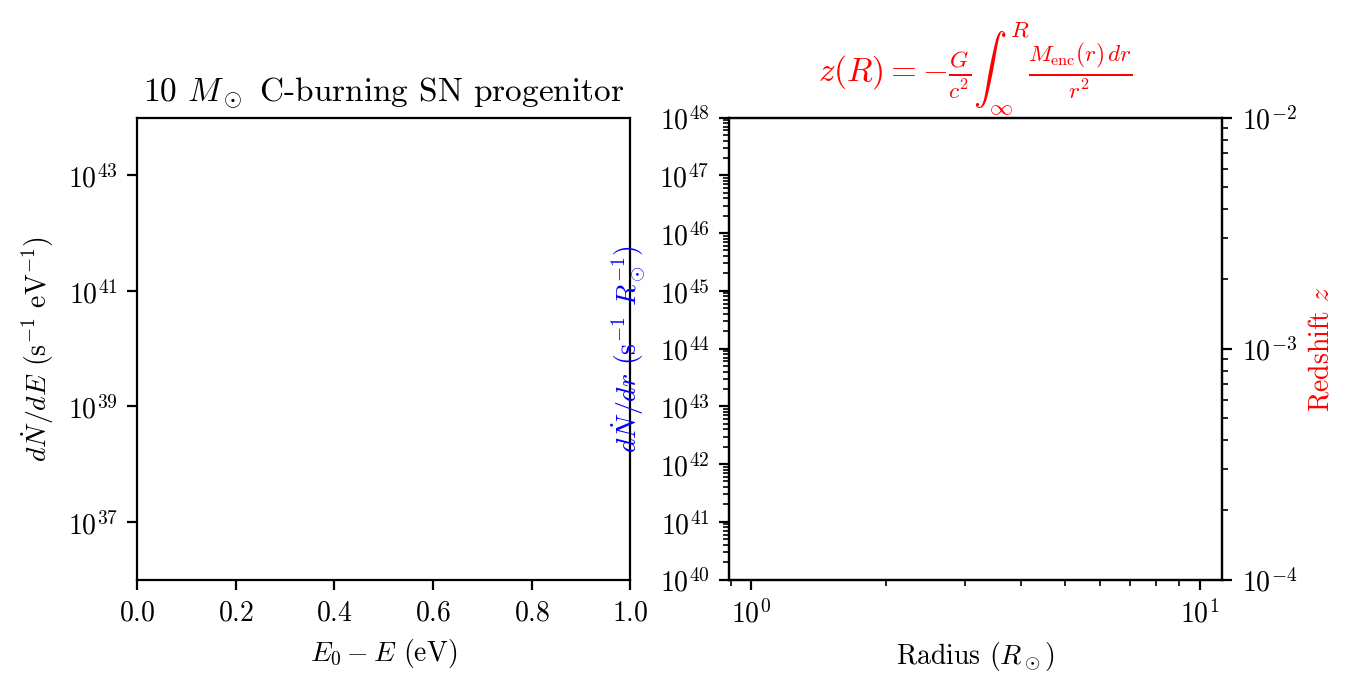

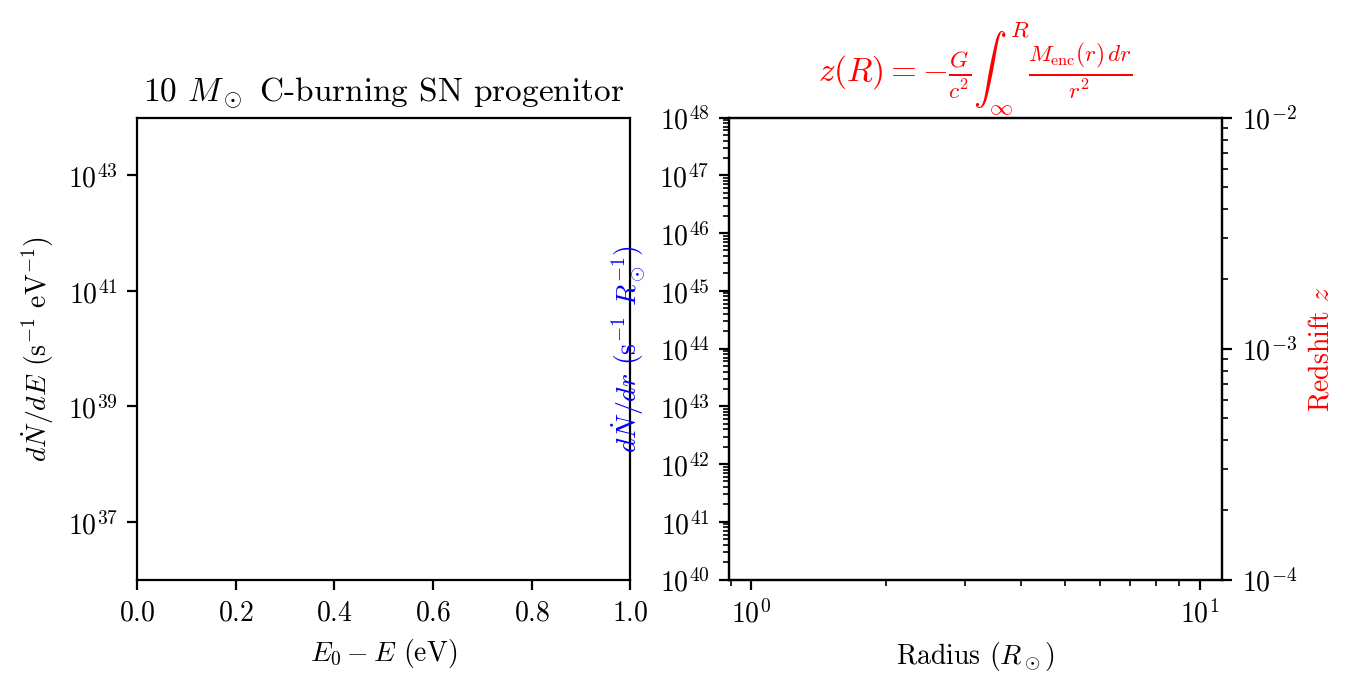

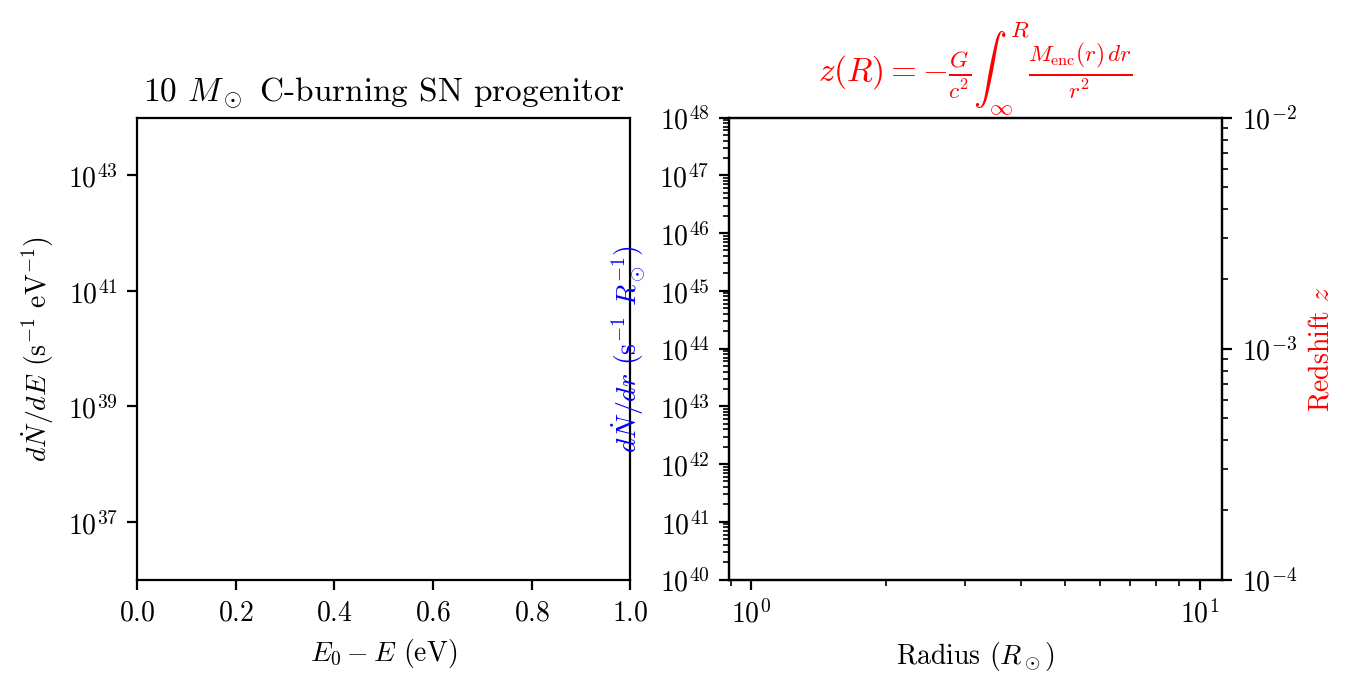

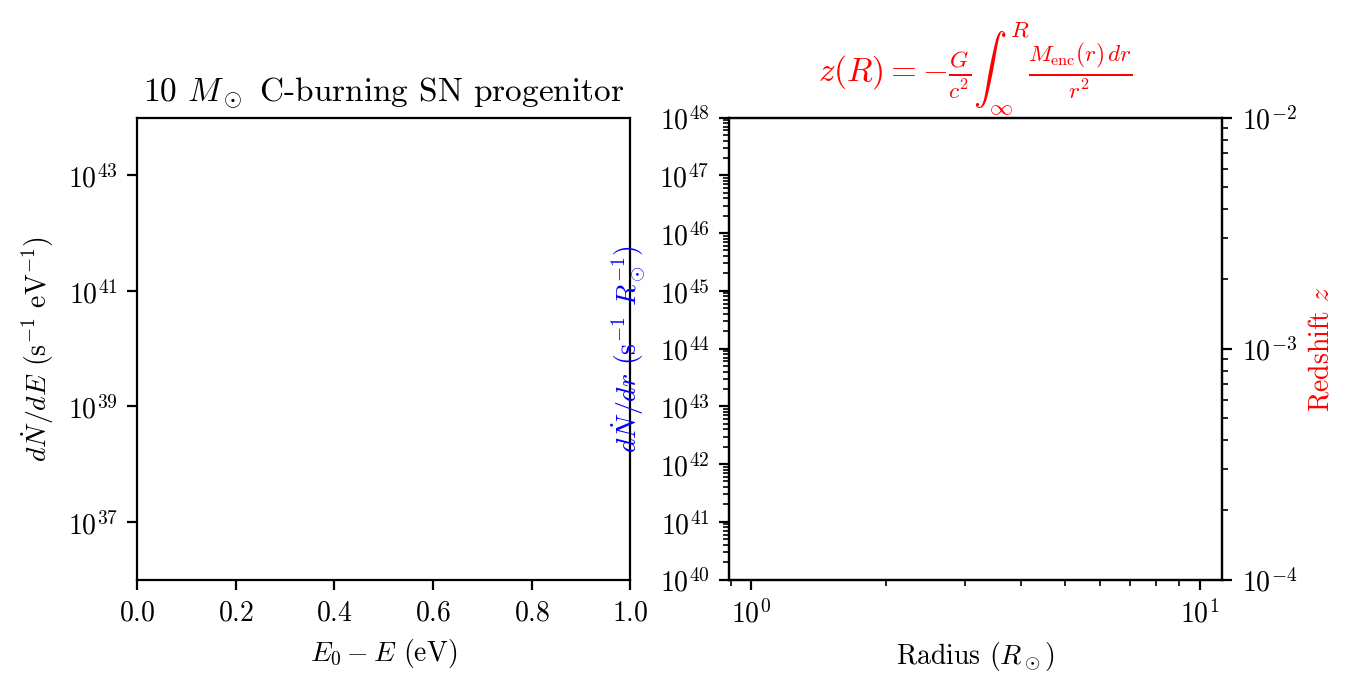

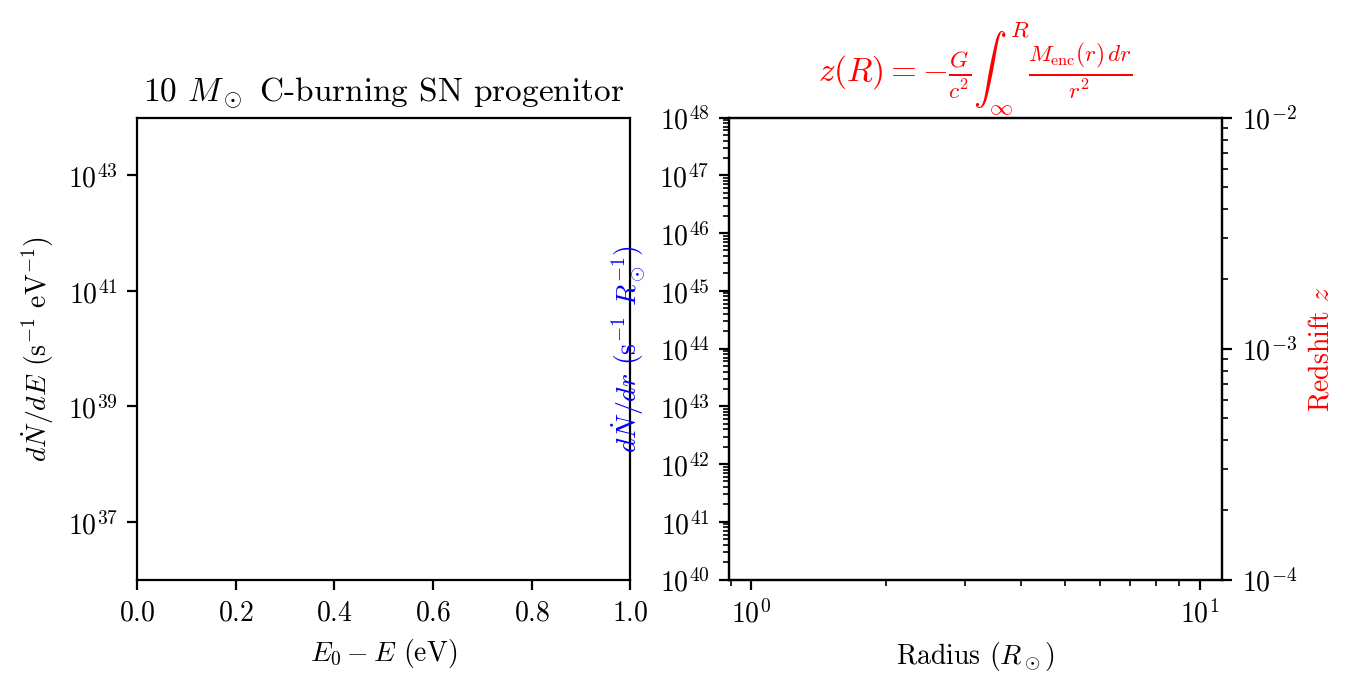

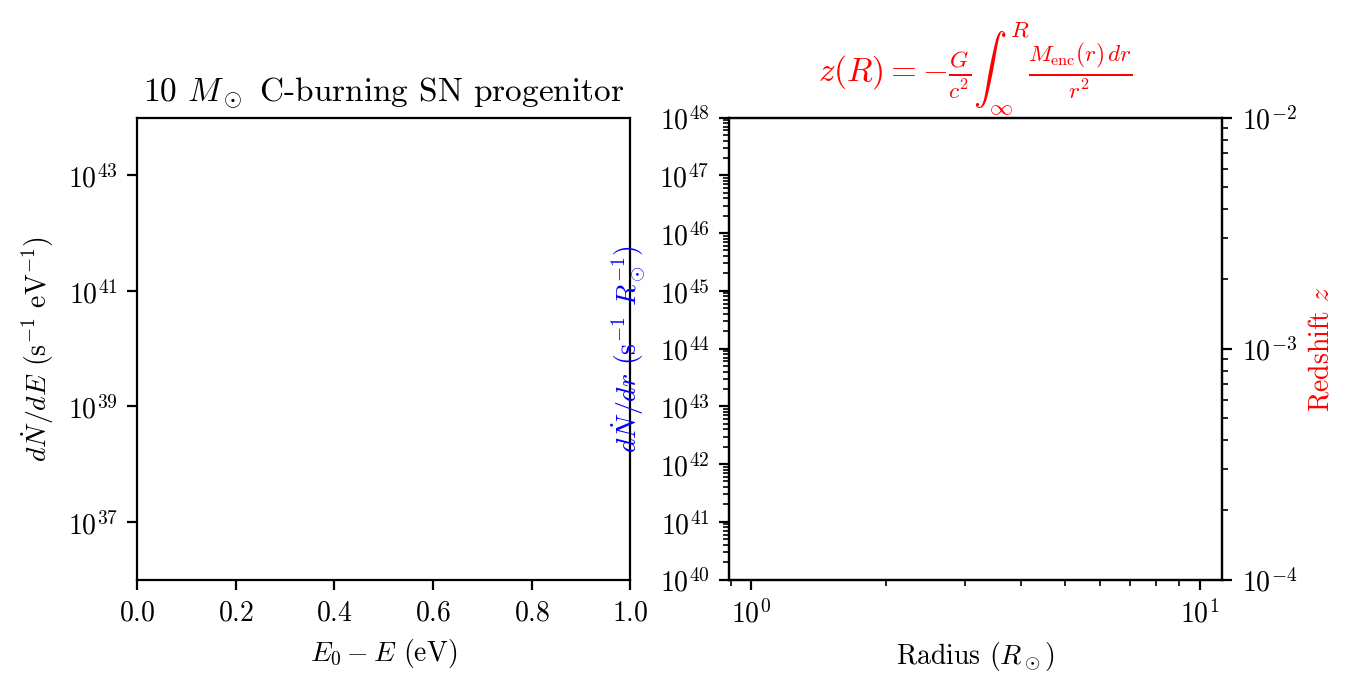

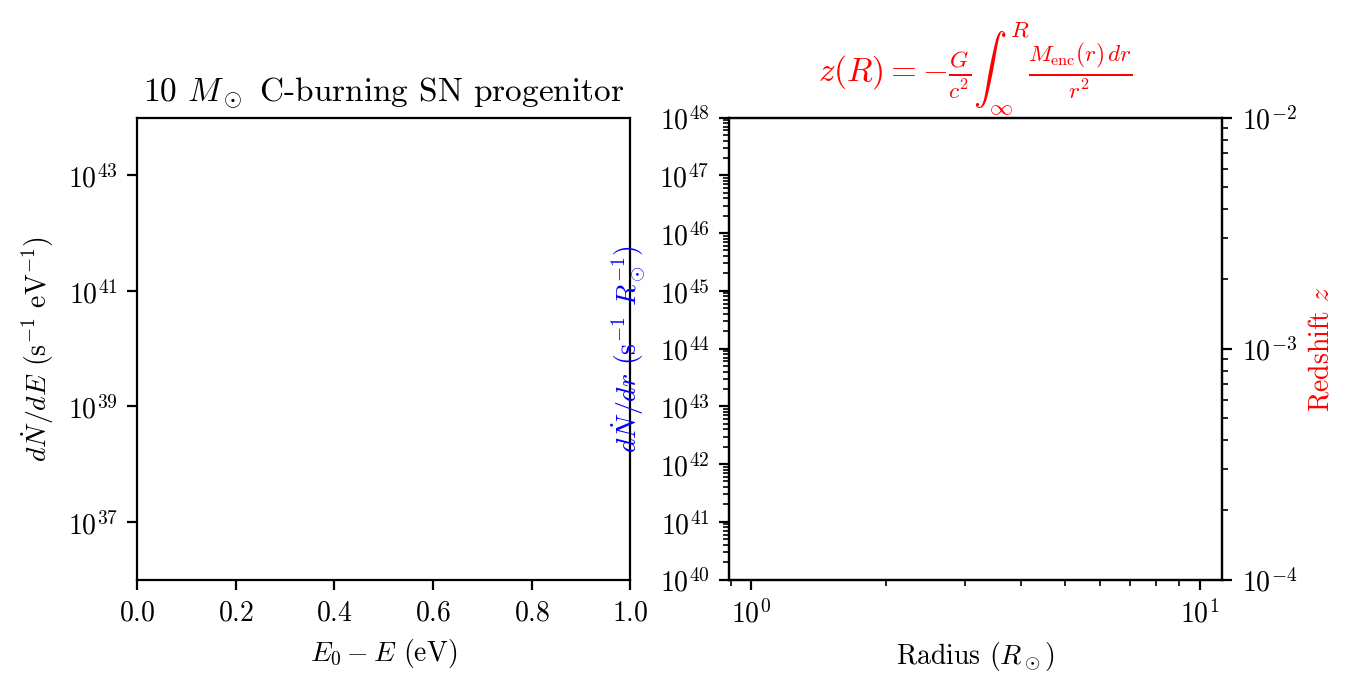

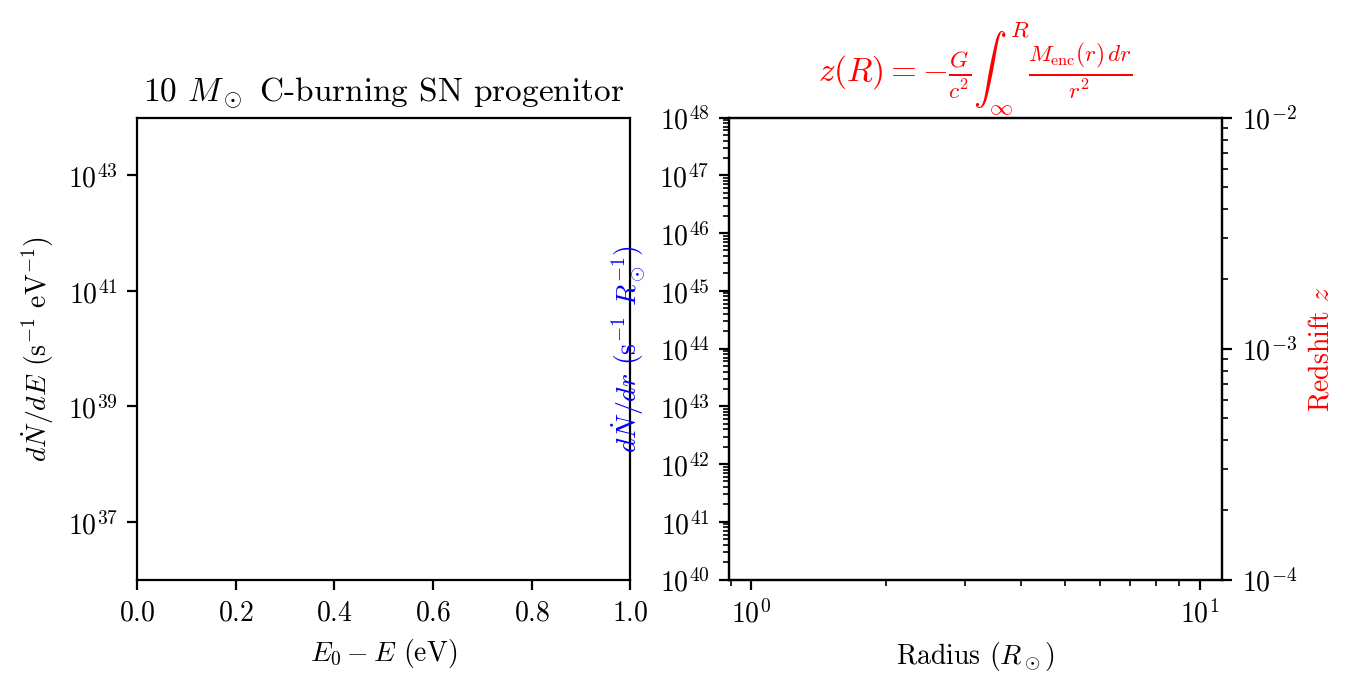

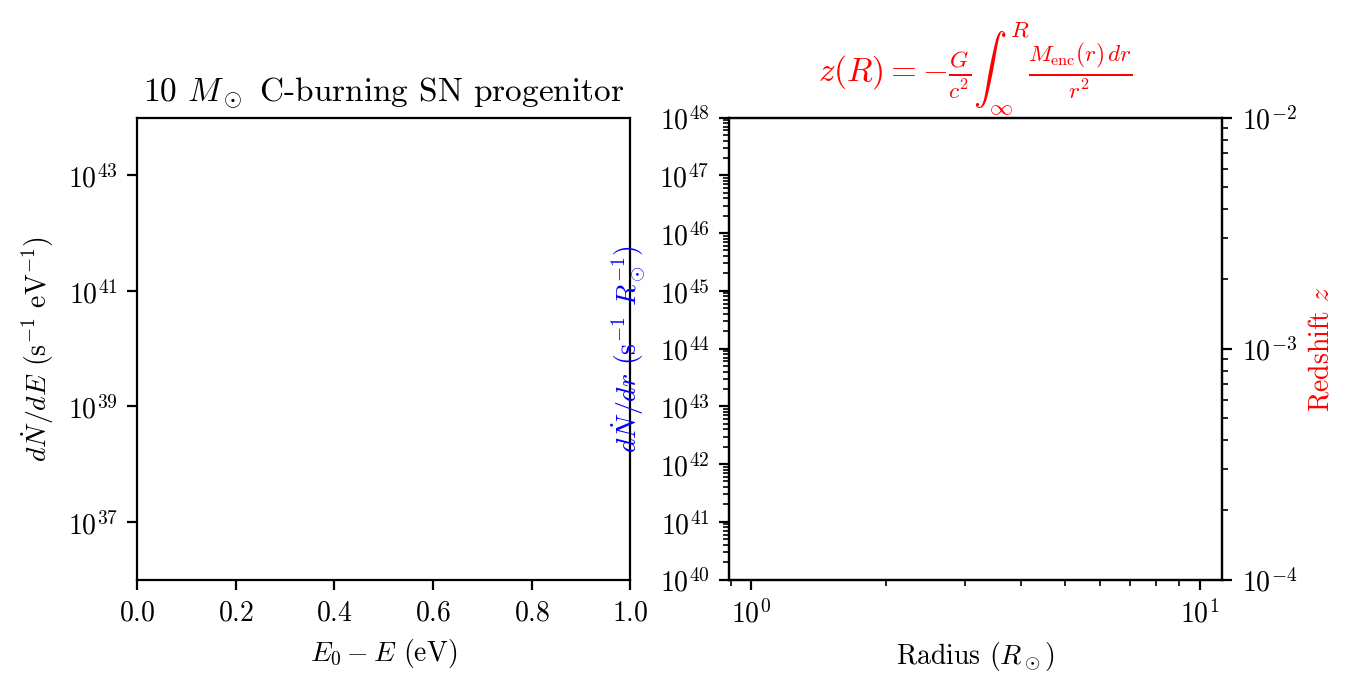

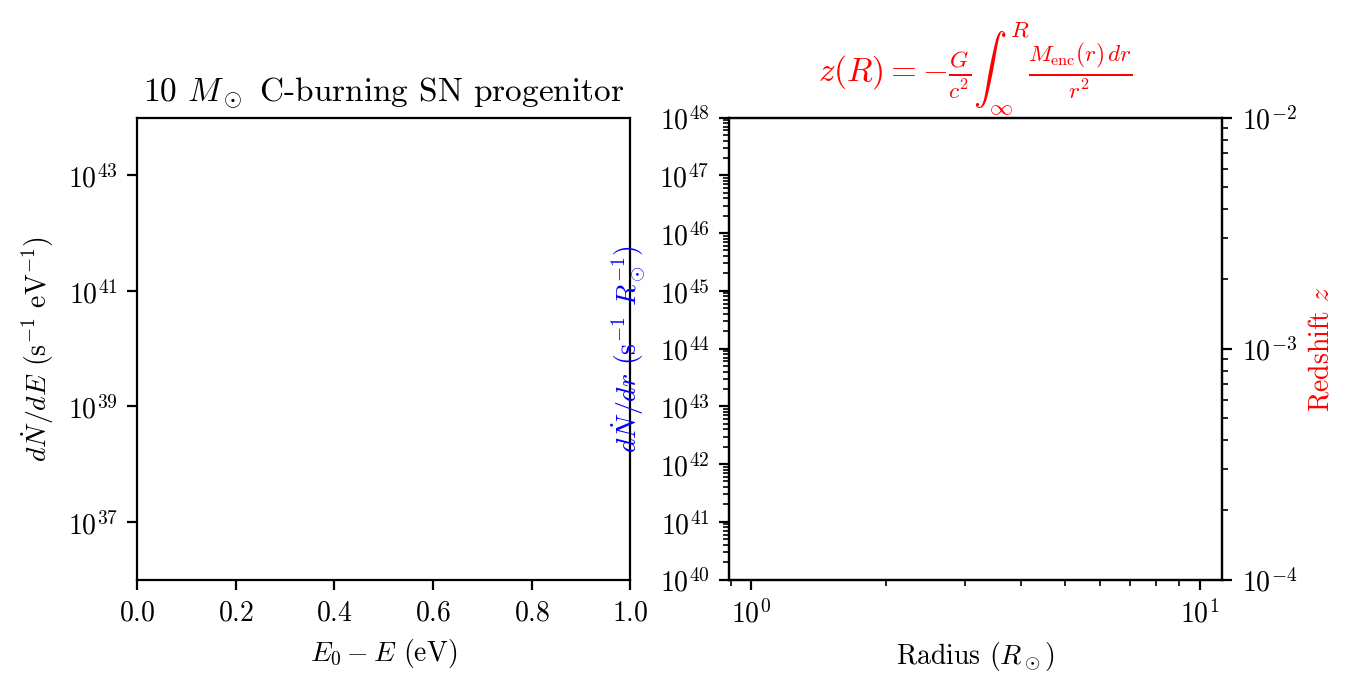

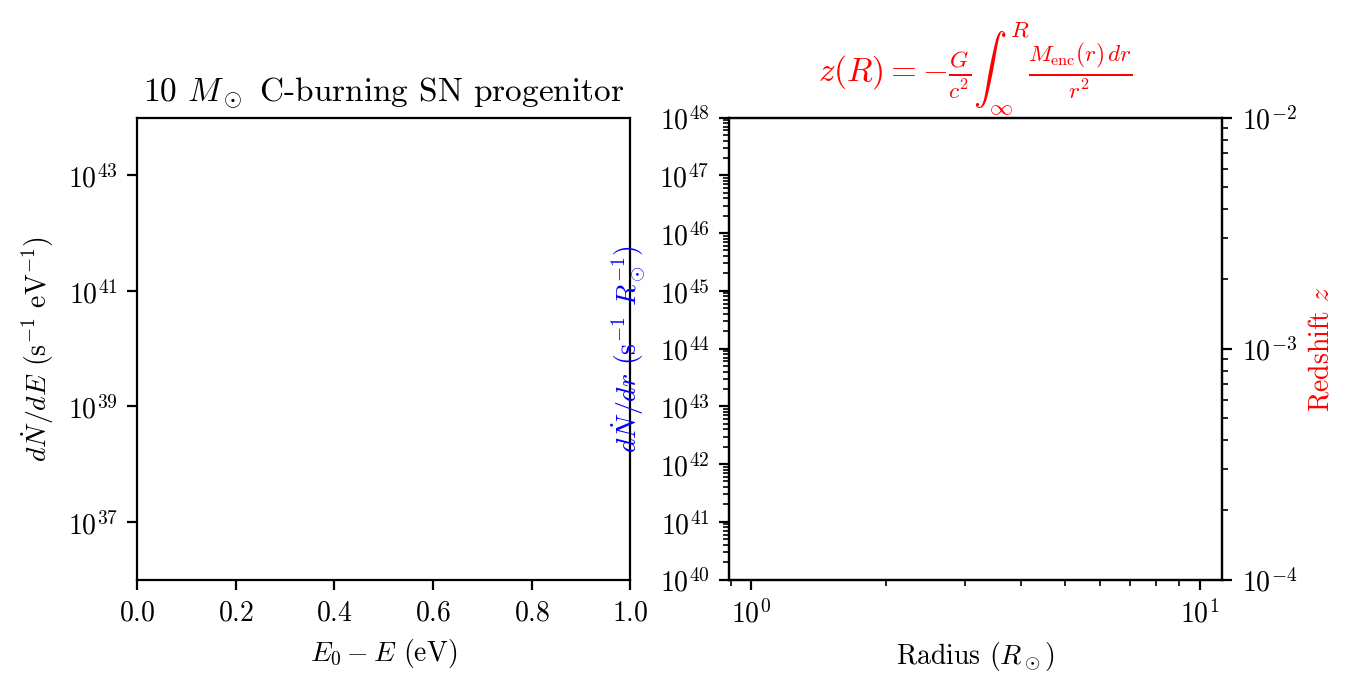

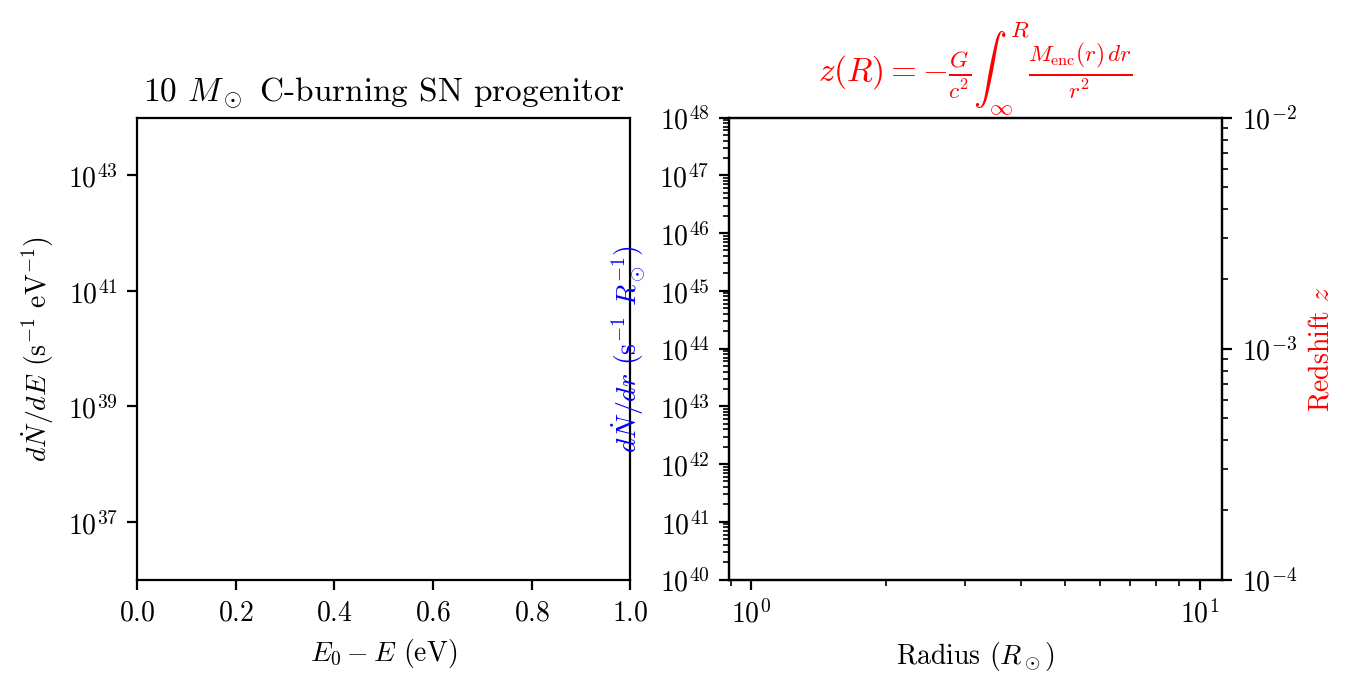

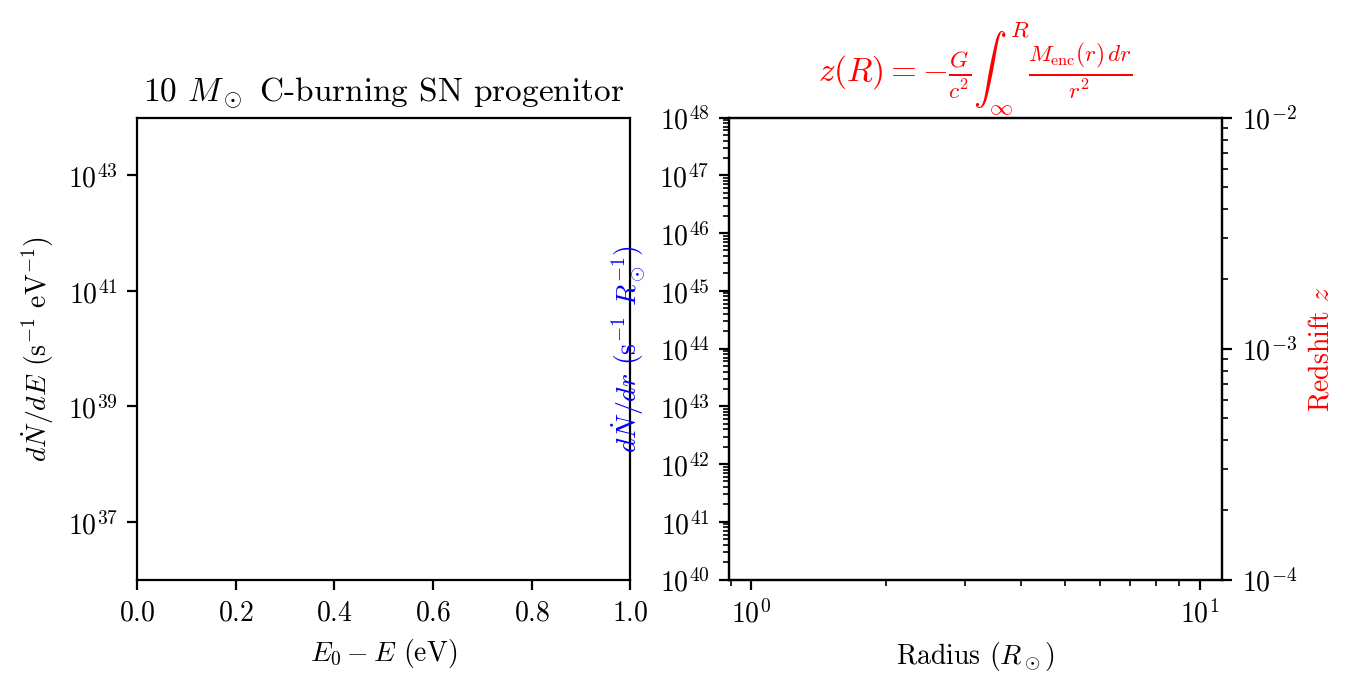

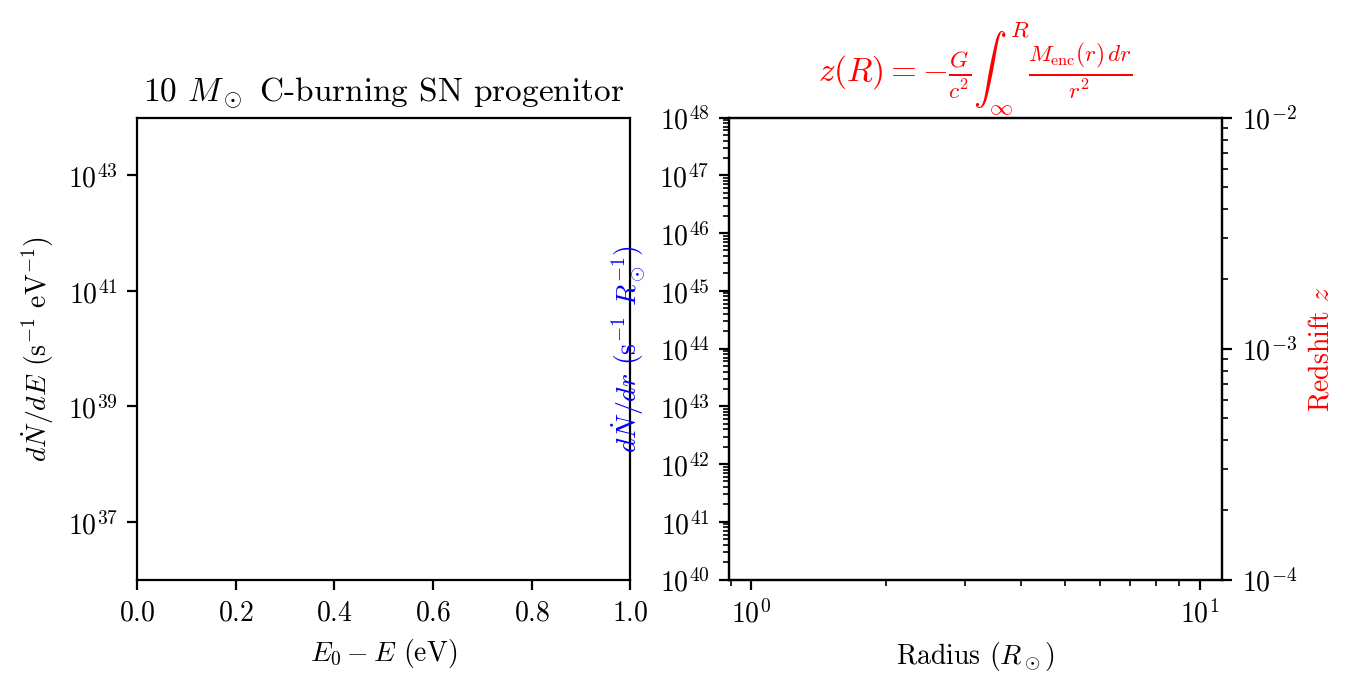

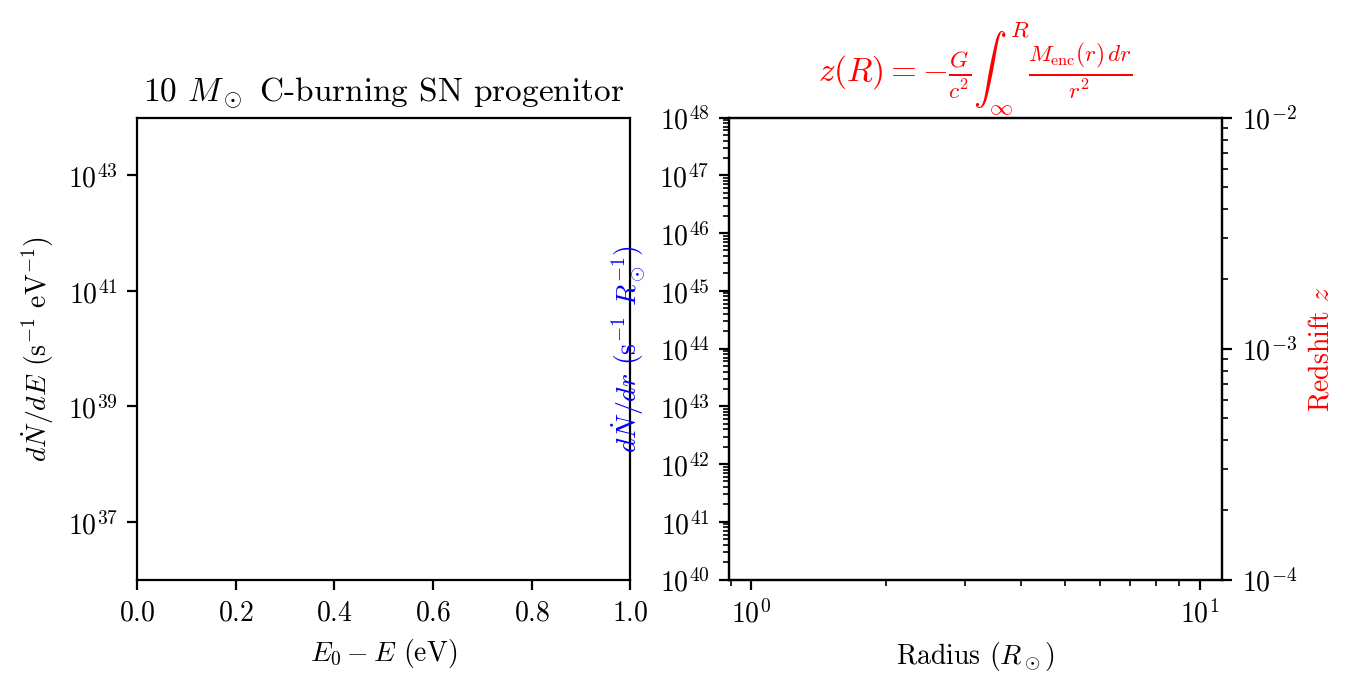

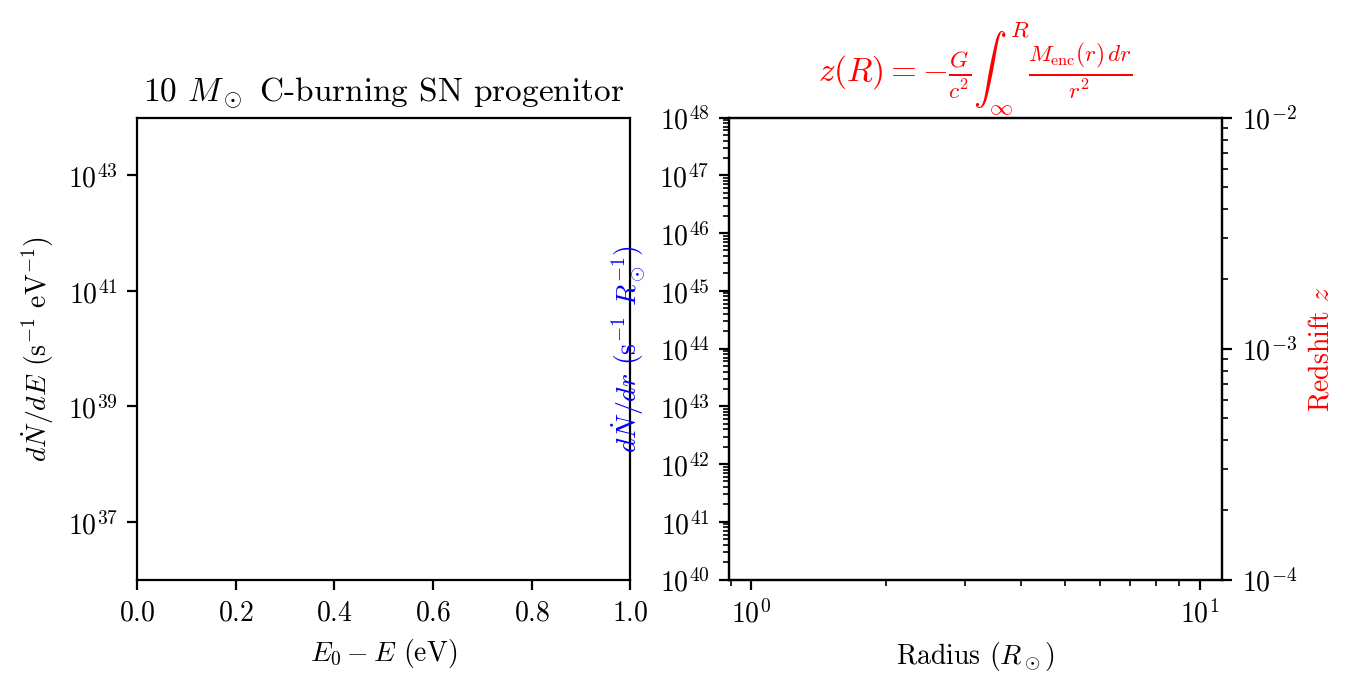

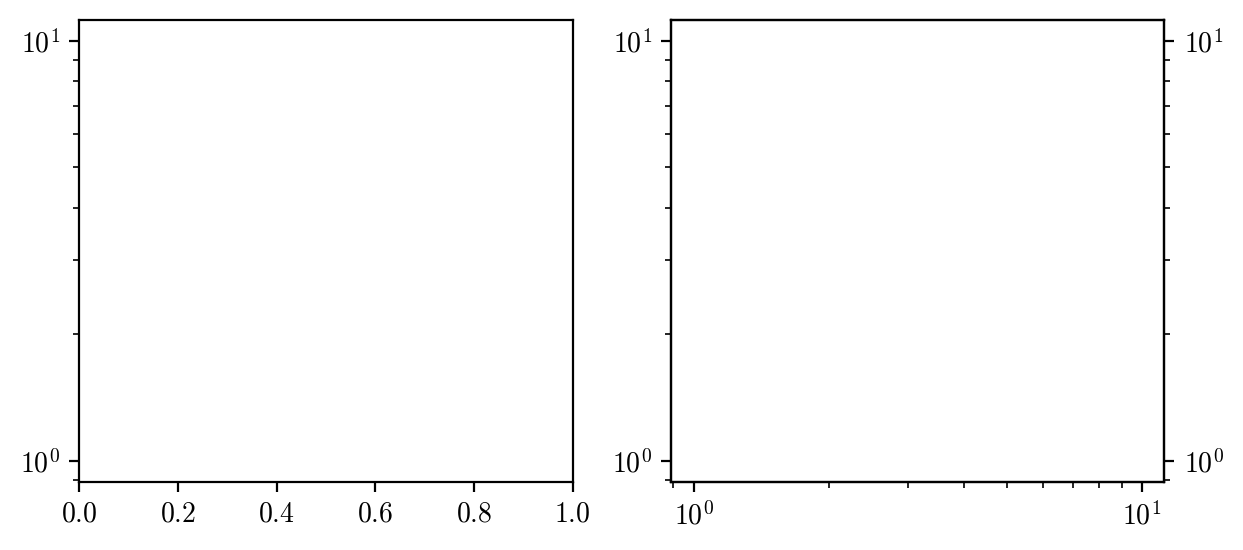

In [96]:
Emean = []
Emin = []
Emax = []
Estd = []
Et = []
for k in range(1300, 3100, 50):

    fig, (hist, nax) = plt.subplots(ncols=2, figsize=(7, 3))
    zax = nax.twinx()
    zax.set_xscale("log")
    zax.set_yscale("log")
    nax.set_yscale("log")
    hist.set_yscale("log")
    # hist.set_xscale("log")
    
    i = list(index["slice"]).index(k)
    hist.set_title(f"{m} $M_\odot$ C-burning SN progenitor")
    nax.set_title(r"$z(R) = -\frac{G}{c^2} \int_\infty^R \frac{M_\mathrm{enc}(r)\, dr}{r^2}$", color="red")
    
    zax.set_ylabel("Redshift $z$", color='red')
    nax.set_xlabel("Radius ($R_\odot$)")
    nax.set_ylabel("$d\dot N/dr$ (s$^{-1}$ $R_\odot^{-1}$)", color='blue')
    hist.set_xlabel("$E_0 - E$ (eV)")
    hist.set_ylabel("$d\dot N/dE$ (s$^{-1}$ eV$^{-1}$)")
    zax.set_ylim(1e-4, 1e-2)
    nax.set_ylim(1e40, 1e48)
    hist.set_ylim(1e36, 1e44)

    # for i in range(1400, 2600, 200):
    s = slices[i]
    r = np.array(s["r (Rsun)"]) * cm_per_Rsun
    dr = np.array(s["dr (cm)"])
    menc = np.array(s["mass enclosed (Msun)"]) * g_per_Msun
    
    z = (G_cgs/c_cgs**2) * np.flip(np.cumsum(np.flip(menc * dr / r**2)))
    
    dN = np.diff(s["num_a (/s)"], prepend=0)
    dNdr = dN/s["dr (cm)"]*cm_per_Rsun
    
    E = -E0_ev * z / (1 + z)
    Ebin = np.arange(-800, 1, 10)
    dNdE, _ = np.histogram(E, weights=dN, bins=Ebin)
    dNdE /= np.diff(Ebin)

    norm = dNdE/np.sum(dNdE)
    Es = 0.5*(Ebin[1:] + Ebin[:-1])
    Emax.append( Es[dNdE>0][0] )
    Emin.append( Es[dNdE>0][-1] )
    Emean.append( np.sum(Es * norm) )
    Estd.append(np.sqrt(np.sum((Es - Emean[-1])**2 * norm)))
    Et.append(t[i])
    
    # plt.sca(zax)
    # plt.plot(r / cm_per_Rsun, z, color='red', alpha=0.5)
    # plt.xlim(1e-4, 0.1)
    
    # plt.sca(nax)
    # plt.plot(r / cm_per_Rsun, dNdr, color='blue', alpha=0.5)
    
    # plt.sca(hist)
    # plt.plot(Es, dNdE, color='black', alpha=0.5)
    # plt.xlim(-400, 0)
    # plt.text(s=f"$t-t_{{cc}} = -{t[i]:.0f}$ y", x=-200, y=1e43)
    # plt.text(s=f"slice {k}", x=-200, y=1e42)
    # fig.tight_layout()
    # plt.savefig(f"redshift/{m}_{k}.png")
    
    # plt.show()
    # plt.close()

In [97]:
Emin = np.array(Emin)
Emax = np.array(Emax)
Emean = np.array(Emean)
Estd = np.array(Estd)
Et = np.array(Et)

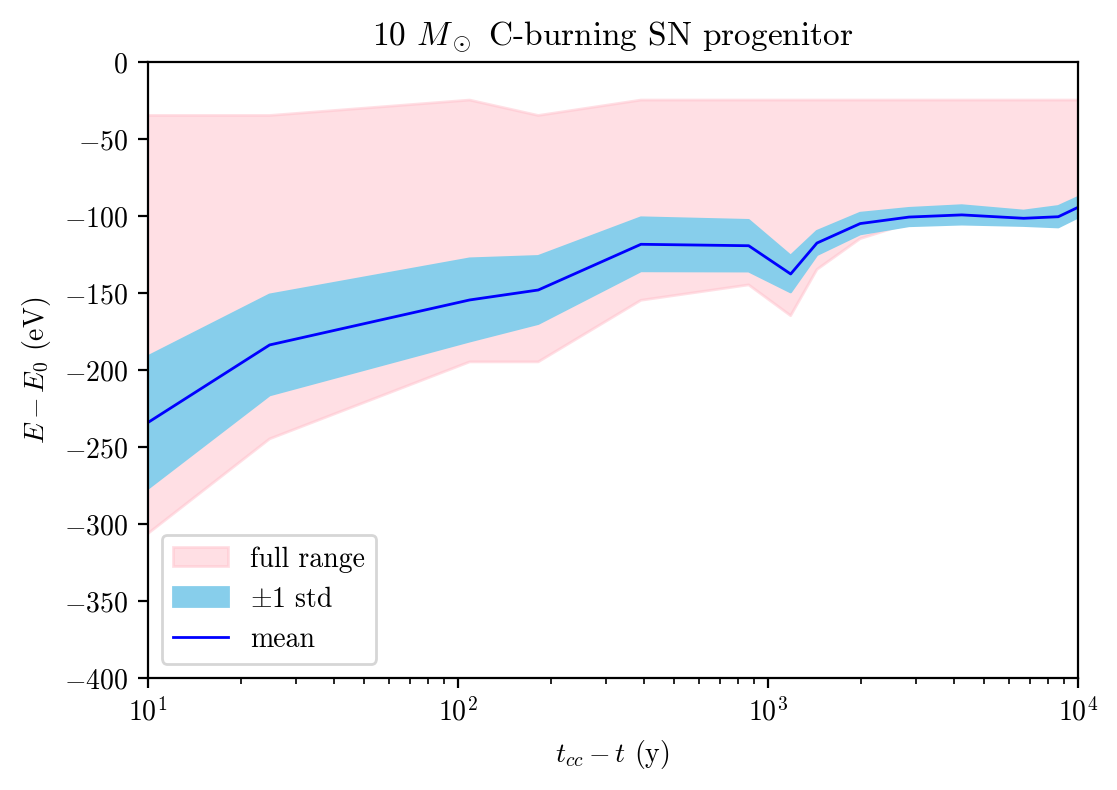

In [98]:
plt.fill_between(Et, Emin, Emax, alpha=0.5, color='pink', label='full range')
plt.fill_between(Et, Emean-Estd, Emean+Estd, color='skyblue', label='$\pm1$ std')
plt.plot(Et, Emean, color='blue', lw=1, label='mean')
plt.xlabel(r'$t_{cc} - t$ (y)')
plt.ylim(-400, 0)
plt.ylabel(r'$E - E_0$ (eV)')
plt.legend()
plt.title(f"{m} $M_\odot$ C-burning SN progenitor")
plt.xlim(10, 1e4)
plt.gca().set_xscale('log')
plt.savefig(f'redshift/{m}_summary.png')
plt.show()
# plt.ylim(-500, 0)

1500


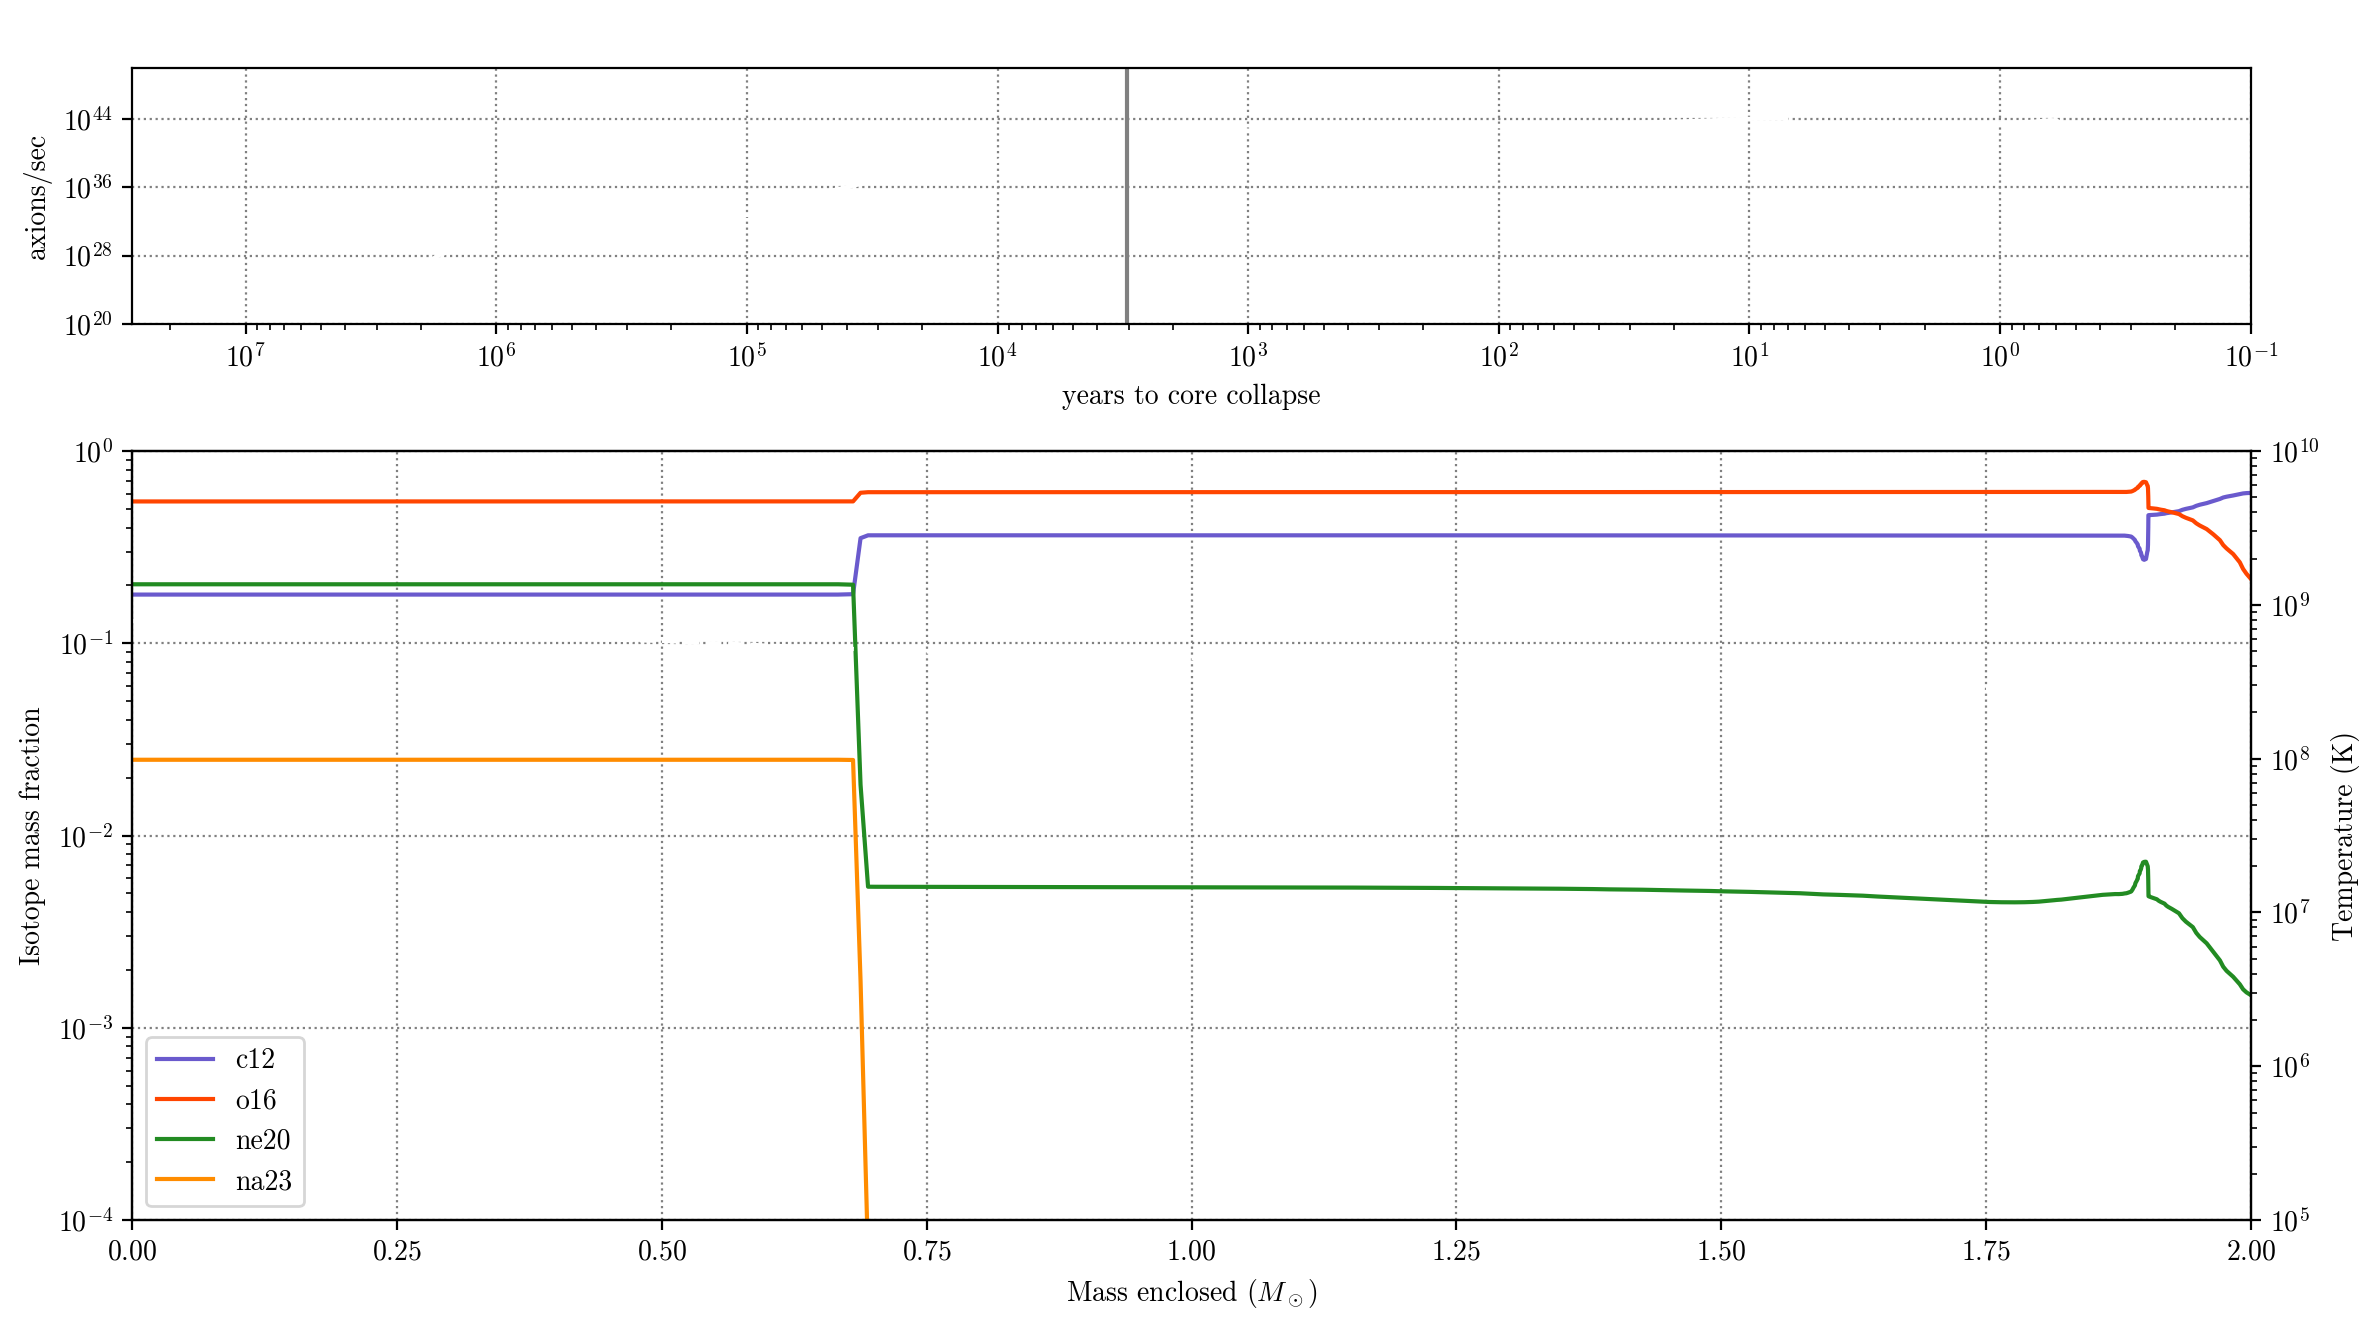

In [67]:

fig, (tax, Xax) = plt.subplots(nrows=2, figsize=(12, 9*0.75), gridspec_kw={'height_ratios': [1, 3]})
Tax = Xax.twinx()


iCstart = 1500
iCend = 10000
for (i, s) in enumerate(slices):
    if i not in range(iCstart, iCend):
        continue

    if i % 100 == 0:
        print(i)

    plt.sca(tax)
    tax.set_yscale('log')
    tax.set_xscale('log')
    plt.plot(t, N, c='white')
    plt.axvline(t[i], c='gray')
    plt.ylim(1e20, 1e50)
    plt.xlim(np.max(t), 1e-1)
    plt.title("Axion flux from a 9 $M_\odot$ star with $g_{eff} = 10^{-10}$", c="white")
    plt.xlabel("years to core collapse")
    plt.ylabel("axions/sec")
    plt.grid(c="gray", ls=":")
    
    plt.sca(Xax)
    Xax.set_yscale('log')

    m = np.array(s["mass enclosed (Msun)"])

    for iso in isotopes:
        plt.plot(m, np.array(s["X_"+iso]), label=iso, c=color[iso])

    plt.ylim(1e-4, 1)
    plt.xlim(0, 2)
    plt.xlabel("Mass enclosed ($M_\odot$)")
    plt.ylabel("Isotope mass fraction")
    plt.grid(c="gray", ls=":")
    plt.legend()

    plt.sca(Tax)
    Tax.set_yscale('log')
    plt.plot(m, np.array(s["T (K)"]), ls="--", c='white')
    plt.ylim(1e5, 1e10)
    plt.ylabel("Temperature (K)")
    plt.tight_layout()


    plt.savefig(f'slice3/{i:05}.png')
    plt.show()
    tax.clear()
    Xax.clear()
    Tax.clear()
    break